In [46]:
import torch
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

In [47]:


# Hàm IoU
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [61]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    average_precisions = []
    epsilon = 1e-6

    # Duyệt qua từng lớp
    for c in range(num_classes):
        # Lọc ra các hộp detection và hộp groud truth trong lớp đó
        detections = [detection for detection in pred_boxes if detection[1] == c]
        ground_truths = [box for box in true_boxes if box[1] == c]


        # Gom các hộp groud truth lại cùng một nhóm theo từng ảnh
        boxes_truth_img = Counter([gt[0] for gt in ground_truths])
        # Chuyển thành tensor để xác định TP và FP
        for key, value in boxes_truth_img.items():
            boxes_truth_img[key] = torch.zeros(value)

        # Định nghĩa TP và FP
        num_detection = len(detections)
        TP = torch.zeros(num_detection)
        FP = torch.zeros(num_detection)
        total_true_bboxes = len(ground_truths)
        
        # Nếu không có hộp đúng nào mà chứa class đó, bỏ qua phần sau
        if total_true_bboxes == 0:
            continue


        # Sắp xếp giảm dần chỉ số score của detection
        detections.sort(key = lambda x : x[2], reverse = True)

        # Duyệt qua từng detection
        for detection_idx, detection in enumerate(detections):
            # Lấy ra các truth box của image chứa detection đang xét
            ground_truth_img = [box for box in ground_truths if box[0] == detection[0]]

            num_gts = len(ground_truth_img)     
            best_iou = 0
            # Kiểm tra iou của từng box trong ảnh vừa lấy ra
            for gt_idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:])
                    , torch.tensor(gt[3:])
                    , box_format = box_format
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx


            # Kiểm tra với threshold iou
            if best_iou > iou_threshold:
                if boxes_truth_img[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    boxes_truth_img[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                TP[detection_idx] = 0
                
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)      



        
        

In [49]:
# def mean_average_precision(
#     pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
# ):
#     """
#     Calculates mean average precision 

#     Parameters:
#         pred_boxes (list): list of lists containing all bboxes with each bboxes
#         specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
#         true_boxes (list): Similar as pred_boxes except all the correct ones 
#         iou_threshold (float): threshold where predicted bboxes is correct
#         box_format (str): "midpoint" or "corners" used to specify bboxes
#         num_classes (int): number of classes

#     Returns:
#         float: mAP value across all classes given a specific IoU threshold 
#     """

#     # list storing all AP for respective classes
#     average_precisions = []

#     # used for numerical stability later on
#     epsilon = 1e-6

#     for c in range(num_classes):
#         detections = []
#         ground_truths = []

#         # Go through all predictions and targets,
#         # and only add the ones that belong to the
#         # current class c
#         for detection in pred_boxes:
#             if detection[1] == c:
#                 detections.append(detection)

#         for true_box in true_boxes:
#             if true_box[1] == c:
#                 ground_truths.append(true_box)

#         # find the amount of bboxes for each training example
#         # Counter here finds how many ground truth bboxes we get
#         # for each training example, so let's say img 0 has 3,
#         # img 1 has 5 then we will obtain a dictionary with:
#         # amount_bboxes = {0:3, 1:5}
#         amount_bboxes = Counter([gt[0] for gt in ground_truths])

#         # We then go through each key, val in this dictionary
#         # and convert to the following (w.r.t same example):
#         # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
#         for key, val in amount_bboxes.items():
#             amount_bboxes[key] = torch.zeros(val)

#         # sort by box probabilities which is index 2
#         detections.sort(key=lambda x: x[2], reverse=True)
#         TP = torch.zeros((len(detections)))
#         FP = torch.zeros((len(detections)))
#         total_true_bboxes = len(ground_truths)
        
#         # If none exists for this class then we can safely skip
#         if total_true_bboxes == 0:
#             continue

#         for detection_idx, detection in enumerate(detections):
#             # Only take out the ground_truths that have the same
#             # training idx as detection
#             ground_truth_img = [
#                 bbox for bbox in ground_truths if bbox[0] == detection[0]
#             ]

#             num_gts = len(ground_truth_img)
#             best_iou = 0

#             for idx, gt in enumerate(ground_truth_img):
#                 iou = intersection_over_union(
#                     torch.tensor(detection[3:]),
#                     torch.tensor(gt[3:]),
#                     box_format=box_format,
#                 )

#                 if iou > best_iou:
#                     best_iou = iou
#                     best_gt_idx = idx

#             if best_iou > iou_threshold:
#                 # only detect ground truth detection once
#                 if amount_bboxes[detection[0]][best_gt_idx] == 0:
#                     # true positive and add this bounding box to seen
#                     TP[detection_idx] = 1
#                     amount_bboxes[detection[0]][best_gt_idx] = 1
#                 else:
#                     FP[detection_idx] = 1

#             # if IOU is lower then the detection is a false positive
#             else:
#                 FP[detection_idx] = 1

#         TP_cumsum = torch.cumsum(TP, dim=0)
#         FP_cumsum = torch.cumsum(FP, dim=0)
#         recalls = TP_cumsum / (total_true_bboxes + epsilon)
#         precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
#         precisions = torch.cat((torch.tensor([1]), precisions))
#         recalls = torch.cat((torch.tensor([0]), recalls))
#         # torch.trapz for numerical integration
#         average_precisions.append(torch.trapz(precisions, recalls))

#     return sum(average_precisions) / len(average_precisions)

In [68]:
# =====================================
# 3️⃣ SINH DỮ LIỆU GIẢ LẬP
# =====================================
# true_boxes = [
#     [0, 0, 1.0, 0.1, 0.1, 0.4, 0.4],  # GT1
#     [0, 0, 1.0, 0.5, 0.5, 0.8, 0.8],  # GT2
# ]

# pred_boxes = [
#     [0, 0, 0.9, 0.1, 0.12, 0.38, 0.4],  # TP (match GT1)
#     [0, 0, 0.8, 0.5, 0.5, 0.75, 0.85],  # TP (match GT2)
#     [0, 0, 0.6, 0.2, 0.2, 0.5, 0.5],  # FP (IoU thấp)
# ]

true_boxes = [
    [0, 0, 1.0, 0.1, 0.1, 0.4, 0.4],  # Object 1
    [0, 0, 1.0, 0.5, 0.5, 0.8, 0.8],  # Object 2
    [0, 0, 1.0, 0.6, 0.1, 0.9, 0.3],  # Object 3
]

pred_boxes = [
    [0, 0, 0.9, 0.1, 0.1, 0.41, 0.4],  # ✅ TP (match GT1)
    [0, 0, 0.8, 0.5, 0.5, 0.8, 0.81],  # ✅ TP (match GT2)
    [0, 0, 0.7, 0.6, 0.1, 0.8, 0.25], # 😐 hơi lệch, IoU < 0.5 → FP
    [0, 0, 0.6, 0.2, 0.6, 0.4, 0.8],  # ❌ FP (chẳng trùng cái nào)
]

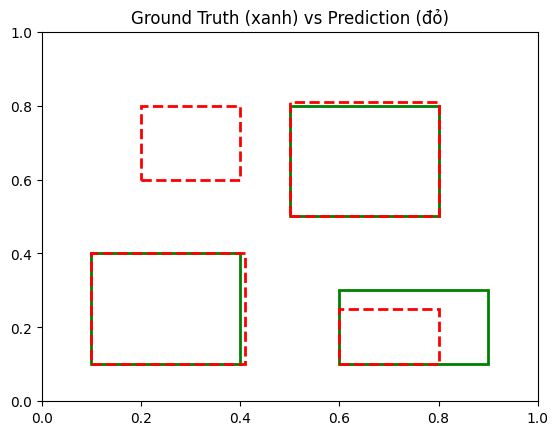

In [69]:

# =====================================
# 4️⃣ VẼ HÌNH TRỰC QUAN
# =====================================
fig, ax = plt.subplots(1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Ground Truth (xanh) vs Prediction (đỏ)")

# Vẽ ground truths
for gt in true_boxes:
    x1, y1, x2, y2 = gt[3:]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='green', facecolor='none', label="GT")
    ax.add_patch(rect)

# Vẽ predicted boxes
for pred in pred_boxes:
    x1, y1, x2, y2 = pred[3:]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label="Pred")
    ax.add_patch(rect)

plt.show()



In [70]:
# =====================================
# 5️⃣ TÍNH M.A.P
# =====================================
mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=1)
print(f"📊 Mean Average Precision (mAP): {mAP:.3f}")

📊 Mean Average Precision (mAP): 0.667
